# Consigna 4

#### Analizar la cantidad de palabras promedio de los turnos de los estudiantes dentro de un diálogo en general, para los diálogos evaluados como positivos (4, 5), y para los diálogos evaluados como negativos (1, 2). ¿La diferencia es significativa entre diálogos positivos y negativos? Correlacionar esta variable con la "nota" que el estudiante pone al tutor en ese diálogo. 

#### Analizar la cantidad de turnos del estudiante y el largo de los diálogos. Correlacionar esta variable con la "nota" del diálogo. Calcular el promedio de cantidad de turnos para los diálogos positivos y negativos. ¿La diferencia es significativa?


## Importación de modulos
---

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from columns_to_keep import C2K
from type_to_fix import T2F

## Carga de la tabla de metadata
---

In [2]:
data_dir = os.path.join('..', 'dataset')
data_file_name = 'datadump-20150801-20171219.csv'
full_data_file_name = os.path.join(data_dir, data_file_name)
df = pd.read_csv(full_data_file_name)
display(df.shape)

(63265, 111)

### Preprocesamiento o curación de la metadata### Preprocesamiento o curación de la metadata

In [3]:
# Remuevo espacios al inicio y final del nombre de la columna
df.columns = [column.strip() for column in df.columns]

# Tomo solo las columnas que vamos a necesitar
df = df[C2K]

# Se corrigen los tipos de los datos 
df = df.astype(T2F)

display(df.shape)

(63265, 39)

## Carga la tabla de mensajes preprocesados
---

In [4]:
data_file_name = 'tiny_yup_messages_preprocessed.csv'
full_data_file_name = os.path.join(data_dir, data_file_name)
dfd = pd.read_csv(full_data_file_name)
display(dfd.shape)

(7441, 6)

## Cálculos
---

### Cálculo del número de turnos de estudiantes por dialogo
#### Pasos:

1. Cueta el numeor de turnos agrupando por `session_id` y `sent_from`
2. Se descartan las filas que no son turnos del tutor o estudiante
3. Se crea una conlumna con el el label adecuado
4. Se remueven las columnas no necesarias

In [5]:
# 1.
st_turnos = dfd.groupby(['session_id','sent_from']).count().reset_index()

# 2.
st_turnos = st_turnos[st_turnos.sent_from=='student']

# 3. 
st_turnos['nturnos'] = st_turnos['text']

# 4.
st_turnos.drop(columns=['created_at', 'sent_to', 'content_type', 'text'], inplace=True)

st_turnos = st_turnos.dropna()

display(st_turnos)

,session_id,sent_from,nturnos
0,300142,student,8
4,300373,student,11
8,300477,student,10
12,300551,student,11
16,300602,student,6
...,...,...,...
1123,325522,student,19
1126,325796,student,5
1130,325896,student,9
1135,326034,student,12


### Cálculo del numero de palabras del estudiante por dialogo

1. Se genera una nueva columna con la longitud en palabras de cada diálogo
2. Se toman las columnas `session_id`, `sent_from` y la nueva columna `twlen`
3. Se selecciona el sub grupo de turnos correspondientes a los estudiantes
4. Se computa el valor medio de la cantidad de palabras por sessión
5. Se crea la columna `student_rating` con el puntaje asignado por el alumno a la session
6. Se eliminan las las filas sin informacion (N/A)
7. Se convierte a tipo entero la variable student_rating

In [6]:
# 1.
tmp = dfd
tmp['twlen'] = tmp.text.apply(lambda x: len(x))

# 2.
dialogos = tmp[['session_id', 'sent_from','twlen']]

# 3.
dialogos = dialogos[dialogos.sent_from=='student']

# 4.
dialogos = dialogos.groupby(['session_id','sent_from']).sum()
dialogos = dialogos.reset_index()

# 5.
dialogos['student_rating'] = dialogos['session_id'].apply(lambda x:df[df.session_id==x].student_rating.values[0])

# 6.
dialogos = dialogos.dropna()

# 7.
dialogos.student_rating = dialogos.student_rating.astype(int)

display(dialogos)

,session_id,sent_from,twlen,student_rating
0,300142,student,195,3
4,300602,student,315,2
6,300833,student,32,3
8,300940,student,236,5
10,301010,student,1083,5
...,...,...,...,...
252,325522,student,1688,5
253,325796,student,129,5
254,325896,student,297,5
255,326034,student,450,5


### Método auxiliar para categorizar las calificaciones

* Negativa, calificacion menor o igual a 2
* Neutra, calificacion igual a 3
* Positiva, calificacion mayor o igual a 4

In [27]:
def student_rating_category(x):
    if x <= 2:
        return 'negativa'
    
    if x >= 4:
        return 'positiva'

    return 'neutra'
 

### Merge de ambos data frames para realizar computos

1. Merge de la ambos data frames
2. Computo de la número de palabras respecto al número de turnos $avtwlen = twlen / nturnos$
3. Categorización de las calificaciones en `negativa`, `neutra` y `positiva`

In [40]:
# 1. 
merged = pd.merge(st_turnos, dialogos, on=['session_id','sent_from'], how='inner')

# 2. 
merged['avtwlen'] = merged.twlen / merged.nturnos

# 3. 
merged['student_rating_cat'] = merged.student_rating.apply(student_rating_category)
display(merged)

,session_id,sent_from,nturnos,twlen,student_rating,avtwlen,student_rating_cat
0,300142,student,8,195,3,24.375000,neutra
1,300602,student,6,315,2,52.500000,negativa
2,300833,student,4,32,3,8.000000,neutra
3,300940,student,9,236,5,26.222222,positiva
4,301010,student,22,1083,5,49.227273,positiva
...,...,...,...,...,...,...,...
210,325522,student,19,1688,5,88.842105,positiva
211,325796,student,5,129,5,25.800000,positiva
212,325896,student,9,297,5,33.000000,positiva
213,326034,student,12,450,5,37.500000,positiva


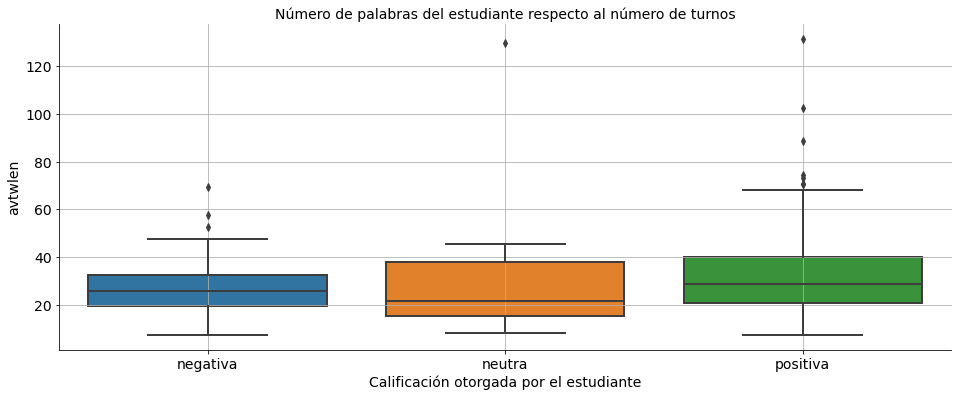

In [41]:
plt.figure(figsize=(16,6))
sns.boxplot(y='avtwlen', x='student_rating_cat',data=merged, order=['negativa', 'neutra', 'positiva'], linewidth=2)
plt.grid(True)
plt.title("Número de palabras del estudiante respecto al número de turnos", fontsize=14)
plt.xlabel('Calificación otorgada por el estudiante', fontsize=14)
plt.ylabel('avtwlen', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine()

### Gráfico de pares para analizar cualitativamente correlación entre las variables `nturnos`, `twlen`, `student_rating`

<Figure size 432x288 with 0 Axes>

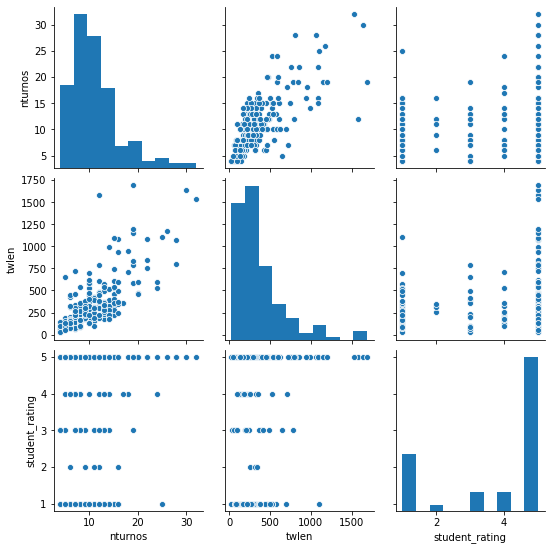

In [8]:
plt.figure()
sns.pairplot(merged[['nturnos','twlen','student_rating']])

### Cómputo del coeficiente de correlación entre las variables `counts`, `twlen`, `student_rating`

In [10]:
merged[['nturnos','twlen', 'student_rating']].corr(method='spearman')

,nturnos,twlen,student_rating
nturnos,1.000000,0.703499,0.140110
twlen,0.703499,1.000000,0.205918
student_rating,0.140110,0.205918,1.000000


### Histograma de cantidad de turnos discriminado respecto a la calificación positiva o negativa.

Consideraciones: 

* Calificación positiva asume un valor en el rango 4 a 5
* Calificación negativa asume un valor en el rango 1 a 2.

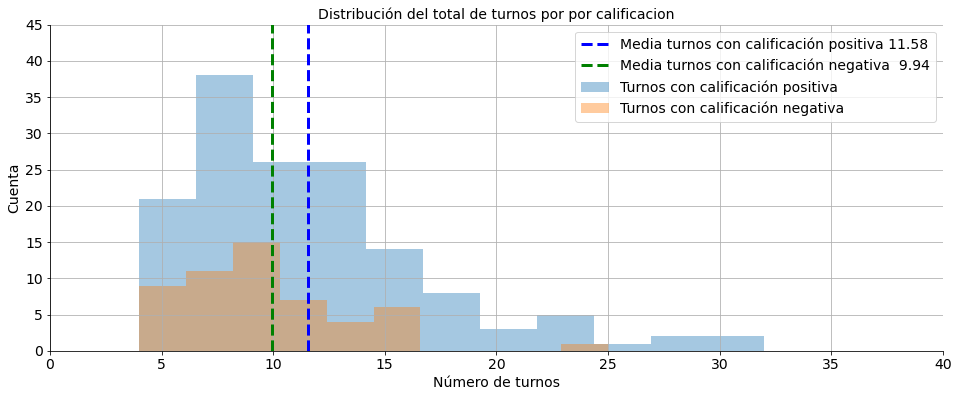

In [11]:
mean_turno_pcal = merged[merged.student_rating>=4].nturnos.mean()
mean_turno_ncal = merged[merged.student_rating<=2].nturnos.mean()

plt.figure(figsize=(16,6))
sns.distplot(merged[merged.student_rating>=4].nturnos, kde=False, label='Turnos con calificación positiva')
sns.distplot(merged[merged.student_rating<=2].nturnos, kde=False, label='Turnos con calificación negativa')
plt.plot([mean_turno_pcal, mean_turno_pcal], [0,60], '--b', linewidth=3, label=f'Media turnos con calificación positiva {mean_turno_pcal:.2f}')
plt.plot([mean_turno_ncal, mean_turno_ncal], [0,60], '--g', linewidth=3, label=f'Media turnos con calificación negativa  {mean_turno_ncal:.2f}')
plt.grid(True)
plt.title("Distribución del total de turnos por por calificacion", fontsize=14)
plt.xlabel('Número de turnos', fontsize=14)
plt.ylabel('Cuenta', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.xlim([0, 40])
plt.ylim([0, 45])
sns.despine()

### Análisis:

* Del análisis cualitativo de los gráficos de pares no se observa correlación entre la varaible `student_rating` y las variables `nturnos` y `twlen` que representan la cantidad de turnos por diálogo la cantidad de palabras por diálogo.
* Del análisis cualitativo de los gráficos se observa correlacion entre las variables `nturnos` y `twlen`.
* Cuantitivamente se puede comprbar lo anterior por medio del cómputo de los coeficientes de correlación.
* No se observa diferencia significativa en el valor medio de la cantidad turnos en sesiones con calificacion negativa o positiva.
